In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install --no-cache-dir git+https://github.com/averinpa/bnm.git@feature/sid-metric
import sys
sys.path.append('C:\my_files\Projects\bnmetrics')

In [3]:
import sys
print(sys.executable)

c:\Users\averi\AppData\Local\Programs\Python\Python39\python.exe


In [5]:
!pip install causal-learn

   ---------------------------------------- 0.0/192.6 kB ? eta -:--:--
   ------------ --------------------------- 61.4/192.6 kB 1.1 MB/s eta 0:00:01
   ------------------------- -------------- 122.9/192.6 kB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 192.6/192.6 kB 1.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
    --------------------------------------- 0.2/9.9 MB 13.0 MB/s eta 0:00:01
   -- ------------------------------------- 0.6/9.9 MB 8.1 MB/s eta 0:00:02
   ----- ---------------------------------- 1.3/9.9 MB 9.3 MB/s eta 0:00:01
   -------- ------------------------------- 2.0/9.9 MB 10.8 MB/s eta 0:00:01
   ------------ --------------------------- 3.0/9.9 MB 12.8 MB/s eta 0:00:01
   --------------- ------------------------ 3.9/9.9 MB 13.9 MB/s eta 0:00:01
   -------------------- ------------------- 5.1/9.9 MB 15.5 MB/s eta 0:00:01
   ------------------------ --------------- 6.1/9.9 MB 16.9 MB/s eta 0:00:01
   ----


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from bnm import BNMetrics, generate_random_dag, dag_to_cpdag, generate_synthetic_data_from_dag
import networkx as nx
import pandas as pd
import numpy as np
from causallearn.search.ConstraintBased.PC import pc

### Structure learning

In [7]:
true_dag = generate_random_dag(n_nodes=40, edge_prob=0.1, seed=55)
data = generate_synthetic_data_from_dag(true_dag, n_samples=1000, stdev=1.0, seed=55)
data = data[list(true_dag.nodes)]

In [8]:
cg = pc(data.values)

Depth=5, working on node 39: 100%|██████████| 40/40 [00:00<00:00, 574.76it/s] 


In [9]:
cg.to_nx_graph()
nx.to_numpy_array(cg.nx_graph).shape

(40, 40)

In [10]:
bn_obj = BNMetrics(G1=true_dag, G2=nx.to_numpy_array(cg.nx_graph))

In [13]:
bn_obj.sid(nodes=['All'], output=False)['incorrect_mat']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

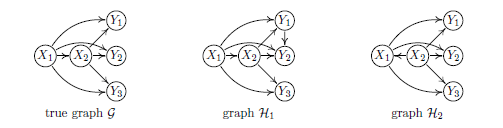

In [3]:
nodes = ['X1', 'X2', 'Y1', 'Y2', 'Y3']

G = np.array([[0, 1, 1, 1, 1], 
             [0, 0, 1, 1, 1], 
             [0, 0, 0, 0, 0], 
             [0, 0, 0, 0, 0], 
             [0, 0, 0, 0, 0]])

H1 = np.array([[0, 1, 1, 1, 1], 
             [0, 0, 1, 1, 1], 
             [0, 0, 0, 1, 0], 
             [0, 0, 0, 0, 0], 
             [0, 0, 0, 0, 0]])

H2 = np.array([[0, 0, 1, 1, 1], 
             [1, 0, 1, 1, 1], 
             [0, 0, 0, 0, 0], 
             [0, 0, 0, 0, 0], 
             [0, 0, 0, 0, 0]])

In [4]:
bnm = BNMetrics(G, H1, node_names=nodes)
bnm.compare_two_bn(nodes=['All'], name1='G', name2='H1')
print((bnm.compare_df(descriptive_metrics='', comparison_metrics=['shd', 'sid'])
       .query("node_name == 'All'")
       .drop(columns='node_name')
       .T
       .reset_index()
       .rename(columns={0:'metric_value', 'index': 'metric'})))
print('\nSID Incorect Interventional distributions')
print(bnm.sid(nodes=['All'], output=False)['incorrect_mat'])

            metric metric_value
0              shd            1
1              sid          0.0
2  sid_lower_bound          0.0
3  sid_upper_bound          0.0

SID Incorect Interventional distributions
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [5]:
bnm = BNMetrics(G, H2, node_names=nodes)
bnm.compare_two_bn(nodes=['All'], name1='G', name2='H2')
print((bnm.compare_df(descriptive_metrics='', comparison_metrics=['shd', 'sid'])
       .query("node_name == 'All'")
       .drop(columns='node_name')
       .T
       .reset_index()
       .rename(columns={0:'metric_value', 'index': 'metric'})))
print('\nSID Incorect Interventional distributions')
print(bnm.sid(nodes=['All'], output=False)['incorrect_mat'])

            metric metric_value
0              shd            1
1              sid          8.0
2  sid_lower_bound          8.0
3  sid_upper_bound          8.0

SID Incorect Interventional distributions
[[0. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [6]:
nodes = ['X1', 'X2', 'X3', 'X4']

DAG = np.array([[0, 0, 0, 0], 
                [0, 0, 1, 0], 
                [1, 0, 0, 0], 
                [1, 0, 1, 0]])

DAG1 = np.array([[0, 1, 0, 0], 
                 [0, 0, 1, 0], 
                 [0, 0, 0, 0], 
                 [0, 0, 1, 0]])

DAG2 = np.array([[0, 0, 0, 0], 
                 [1, 0, 1, 0], 
                 [0, 0, 0, 0], 
                 [0, 0, 1, 0]])

CPDAG = np.array([[0, 1, 0, 0], 
                  [1, 0, 1, 0], 
                  [0, 0, 0, 0], 
                  [0, 0, 1, 0]])

In [7]:
bnm = BNMetrics(DAG, DAG1, node_names=nodes)
bnm.compare_two_bn(nodes=['All'], name1='True DAG', name2='Estimated DAG 1')
print((bnm.compare_df(descriptive_metrics='', comparison_metrics=['shd', 'sid'])
       .query("node_name == 'All'")
       .drop(columns='node_name')
       .T
       .reset_index()
       .rename(columns={0:'metric_value', 'index': 'metric'})))
print('\nSID Incorect Interventional distributions')
print(bnm.sid(nodes=['All'], output=False)['incorrect_mat'])



bnm = BNMetrics(DAG, DAG2, node_names=nodes)
bnm.compare_two_bn(nodes=['All'], name1='DAG', name2='Estimated DAG 2')
print((bnm.compare_df(descriptive_metrics='', comparison_metrics=['shd', 'sid'])
       .query("node_name == 'All'")
       .drop(columns='node_name')
       .T
       .reset_index()
       .rename(columns={0:'metric_value', 'index': 'metric'})))
print('\nSID Incorect Interventional distributions')
print(bnm.sid(nodes=['All'], output=False)['incorrect_mat'])



bnm = BNMetrics(DAG, CPDAG, node_names=nodes)
bnm.compare_two_bn(nodes=['All'], name1='DAG', name2='Estimated CPDAG')
print((bnm.compare_df(descriptive_metrics='', comparison_metrics=['shd', 'sid'])
       .query("node_name == 'All'")
       .drop(columns='node_name')
       .T
       .reset_index()
       .rename(columns={0:'metric_value', 'index': 'metric'})))
print('\nSID Incorect Interventional distributions')
print(bnm.sid(nodes=['All'], output=False)['incorrect_mat'])

            metric metric_value
0              shd            3
1              sid          6.0
2  sid_lower_bound          6.0
3  sid_upper_bound          6.0

SID Incorect Interventional distributions
[[0. 1. 1. 1.]
 [1. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


            metric metric_value
0              shd            3
1              sid          2.0
2  sid_lower_bound          2.0
3  sid_upper_bound          2.0

SID Incorect Interventional distributions
[[0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


            metric metric_value
0              shd            3
1              sid          6.0
2  sid_lower_bound          2.0
3  sid_upper_bound          6.0

SID Incorect Interventional distributions
[[0. 1. 1. 1.]
 [1. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [68]:
bn_obj = BNMetrics(system1, system2)

In [78]:
bn_obj.compare_df(descriptive_metrics='', comparison_metrics=['tp', 'sid'])

,node_name,tp,sid,sid_lower_bound,sid_upper_bound
0,All,2,2524.0,2524.0,2524.0
1,X_67,0,8.0,8.0,8.0
2,X_47,0,10.0,10.0,10.0
3,X_27,0,25.0,25.0,25.0
4,X_94,0,48.0,48.0,48.0
...,...,...,...,...,...
96,X_73,0,11.0,11.0,11.0
97,X_46,1,14.0,14.0,14.0
98,X_95,0,38.0,38.0,38.0
99,X_33,0,30.0,30.0,30.0


In [88]:
bn_obj.graph_dict['X_46']['d1'].nodes()

NodeView(('X_46', 'X_37', 'X_42', 'X_18', 'X_38', 'X_16', 'X_15', 'X_65', 'X_74', 'X_94', 'X_2', 'X_26'))

In [79]:
bn_obj.compare_two_bn(nodes=['X_46'], option=2)

In [82]:
bn_obj.sid(nodes=['X_46'], output=False)['incorrect_mat']

array([[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])